In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def multivariate_normal(x, d, mean, covariance):
    """pdf of the multivariate normal distribution."""
    x_m = x - mean
    return (1. / (np.sqrt((2 * np.pi)**d * np.linalg.det(covariance))) * 
            np.exp(-(np.linalg.solve(covariance, x_m).T.dot(x_m)) / 2))
def highlight_max(data, color='yellow'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_max = data == data.max()
        return [attr if v else '' for v in is_max]
    else:  # from .apply(axis=None)
        is_max = data == data.max().max()
        return pd.DataFrame(np.where(is_max, attr, ''),
                            index=data.index, columns=data.columns)

In [187]:
def generate_GMM_samples(prior,number_of_samples,sig1,sig2,sig3,u1,u2,u3):
    '''
    Args:
    prior of class 1= prior[0]
    prior of class 2 = prior[1]
    prior of class 3 = 1-prior[0]-prior[1]
    
    number_of_samples
    
    class 1- u_1, sig_1
    class 2- u_2, sig_2
    class 2- u_3, sig_3
    
    x is samples from zero-mean identity-covariance Gaussian sample generators

    generating class 1- A1*x+b1
    generating class 2- A2*x+b2
    generating class 2- A3*x+b3
    
    Minimizing P(error) implies MAP estimate. 
    
    For MAP, we need to find un-normalized posterior- P(x|L=i)P(L=i).  Let us call it Check(i) for class i. 
   
    Check(L=1)=N(u_1, sig_1)*Prior(L=1)
    Check(L=2)=N(u_2, sig_2)*Prior(L=2)
    Check(L=3)=N(u_3, sig_3)*Prior(L=3)
    
    Decide class i where Check(L=i) is greatest out of i=1 to 3
    
    Count the total misclassifications for class 1, class 2 and class 3
    
    P(error)= Total errors/Total samples
            = Total errors/10000

    '''

    from matplotlib.pyplot import figure
    txt="Plot of data sampled from 3 gaussians along with their MAP estimated class labels. "
    fig = plt.figure(figsize=(20,20));
    fig.text(.35,0.09,txt,fontsize=15);
    samples_class1=[]
    samples_class2=[]
    samples_class3=[]
    sig_1=np.matrix(sig1)
    sig_2=np.matrix(sig2)
    sig_3=np.matrix(sig3)
    u_1=np.matrix(u1).transpose()
    u_2=np.matrix(u2).transpose()
    u_3=np.matrix(u3).transpose()
    prior=prior
    A1=np.linalg.cholesky(sig_1)
    b1=u_1

    A2=np.linalg.cholesky(sig_2)
    b2=u_2
    
    A3=np.linalg.cholesky(sig_3)
    b3=u_3
        
    zero_mean=[0,0]
    cov=[[1,0],[0,1]]
    for i in range(number_of_samples):
        uniform_sample=np.random.uniform()

        sample_from_zero_mean_identity_covariance=np.random.multivariate_normal(zero_mean,cov,[1]).transpose()

        if uniform_sample<prior[0]:
            '''sample from class class 1'''
            sample=A1.dot(sample_from_zero_mean_identity_covariance)+b1
            samples_class1.append(sample)
        elif uniform_sample>(prior[1]+prior[0]):
            '''sample from class class 3'''
            sample=A3.dot(sample_from_zero_mean_identity_covariance)+b3
            samples_class3.append(sample)
        else:
            '''sample from class class 2'''
            sample=A2.dot(sample_from_zero_mean_identity_covariance)+b2
            samples_class2.append(sample)
                
    samples_class1_final=np.hstack(samples_class1)
    samples_class2_final=np.hstack(samples_class2)
    samples_class3_final=np.hstack(samples_class3)
    a=np.squeeze(np.asarray(samples_class1_final.transpose()[:,1]))
    b=np.squeeze(np.asarray(samples_class1_final.transpose()[:,0]))

    c=np.squeeze(np.asarray(samples_class2_final.transpose()[:,1]))
    d=np.squeeze(np.asarray(samples_class2_final.transpose()[:,0]))

    e=np.squeeze(np.asarray(samples_class3_final.transpose()[:,1]))
    f=np.squeeze(np.asarray(samples_class3_final.transpose()[:,0]))
    

    # A list containing entries of class prediction for labels coming from class i
    classify_1=[]
    classify_2=[]
    classify_3=[]

    for a in samples_class1_final.transpose():
        pred_class_1=multivariate_normal(a.transpose(), 2, u_1, sig_1)
        pred_class_2=multivariate_normal(a.transpose(), 2, u_2, sig_2)
        pred_class_3=multivariate_normal(a.transpose(), 2, u_3, sig_3)
        prediction=0
        if (pred_class_1> pred_class_2) and (pred_class_1> pred_class_3):
            prediction=1
        elif(pred_class_2> pred_class_3):
            prediction=2
        else:
            prediction=3
        classify_1.append(prediction)
        
    
    for a in samples_class2_final.transpose():
        pred_class_1=multivariate_normal(a.transpose(), 2, u_1, sig_1)
        pred_class_2=multivariate_normal(a.transpose(), 2, u_2, sig_2)
        pred_class_3=multivariate_normal(a.transpose(), 2, u_3, sig_3)
        prediction=0
        if (pred_class_1> pred_class_2) and (pred_class_1> pred_class_3):
            prediction=1
        elif(pred_class_2> pred_class_3):
            prediction=2
        else:
            prediction=3
        classify_2.append(prediction)
        
    for a in samples_class3_final.transpose():
        pred_class_1=(multivariate_normal(a.transpose(), 2, u_1, sig_1))*prior[0]
        pred_class_2=(multivariate_normal(a.transpose(), 2, u_2, sig_2))*prior[1]
        pred_class_3=(multivariate_normal(a.transpose(), 2, u_3, sig_3))*(1-prior[0]-prior[1])
        prediction=0
        if (pred_class_1> pred_class_2) and (pred_class_1> pred_class_3):
            prediction=1
        elif(pred_class_2> pred_class_3):
            prediction=2
        else:
            prediction=3
        classify_3.append(prediction)
    df_main=pd.DataFrame(data=[[np.sum(np.array(classify_1)==1),np.sum(np.array(classify_2)==1),np.sum(np.array(classify_3)==1)],\
                   [np.sum(np.array(classify_1)==2),np.sum(np.array(classify_2)==2),np.sum(np.array(classify_3)==2)],
                   [np.sum(np.array(classify_1)==3),np.sum(np.array(classify_2)==3),np.sum(np.array(classify_3)==3)]],columns=[1,2,3])
    df_main.index=[1,2,3]
    
    a=np.squeeze(np.asarray(samples_class1_final.transpose()[:,1]))
    b=np.squeeze(np.asarray(samples_class1_final.transpose()[:,0]))

    c=np.squeeze(np.asarray(samples_class2_final.transpose()[:,1]))
    d=np.squeeze(np.asarray(samples_class2_final.transpose()[:,0]))

    e=np.squeeze(np.asarray(samples_class3_final.transpose()[:,1]))
    f=np.squeeze(np.asarray(samples_class3_final.transpose()[:,0]))
    #plt.scatter(b,a,color='r',marker='*',label='class 1',s=50)
    #plt.scatter(d,c,color='g',marker='*',label='class 2',s=50)
    #plt.scatter(f,e,color='b',marker='*',label='class 3',s=50)
    
    
    df=pd.DataFrame(data= {'x': np.squeeze(np.asarray(samples_class3_final.T[:,0])).tolist(),\
                    'y': np.squeeze(np.asarray(samples_class3_final.T[:,1])).tolist(),\
                    'label': np.squeeze(np.asarray(classify_3))})
    plt.scatter((df[df['label']==3]['x']).values,(df[df['label']==3]['y']).values,label="True label class 3, Decision class 3",marker='^')
    plt.scatter((df[df['label']==2]['x']).values,(df[df['label']==2]['y']).values,label="True label class 3, Decision class 2",marker='*',s=80)
    plt.scatter((df[df['label']==1]['x']).values,(df[df['label']==1]['y']).values,label="True label class 3, Decision class 1",marker='*',s=80)
    

    df=pd.DataFrame(data= {'x': np.squeeze(np.asarray(samples_class2_final.T[:,0])).tolist(),\
                    'y': np.squeeze(np.asarray(samples_class2_final.T[:,1])).tolist(),\
                    'label': np.squeeze(np.asarray(classify_2))})
    plt.scatter((df[df['label']==3]['x']).values,(df[df['label']==3]['y']).values,label="True label class 2, Decision class 3",marker='*',s=80)
    plt.scatter((df[df['label']==2]['x']).values,(df[df['label']==2]['y']).values,label="True label class 2, Decision class 2",marker='^')
    plt.scatter((df[df['label']==1]['x']).values,(df[df['label']==1]['y']).values,label="True label class 2, Decision class 1",marker='*',s=80)
  
    
    df=pd.DataFrame(data= {'x': np.squeeze(np.asarray(samples_class1_final.T[:,0])).tolist(),\
                    'y': np.squeeze(np.asarray(samples_class1_final.T[:,1])).tolist(),\
                    'label': np.squeeze(np.asarray(classify_1))})
    plt.scatter((df[df['label']==3]['x']).values,(df[df['label']==3]['y']).values,label="True label class 1, Decision class 3",marker='*',s=80)
    plt.scatter((df[df['label']==2]['x']).values,(df[df['label']==2]['y']).values,label="True label class 1, Decision class 2",marker='*',s=80)
    plt.scatter((df[df['label']==1]['x']).values,(df[df['label']==1]['y']).values,label="True label class 1, Decision class 1",marker='^')
  
    
    
    plt.legend();
    plt.title('Trivariate gaussian samples',fontsize=15)
    plt.xlabel('x1',fontsize=20)
    plt.ylabel('x2',fontsize=20);
    plt.legend()
    plt.show();
    print ("Samples from class 1 - ", samples_class1_final.shape[1])
    print ("Samples from class 2 - ", samples_class2_final.shape[1])
    print ("Samples from class 3 - ", samples_class3_final.shape[1])
    from matplotlib.pyplot import figure
    txt="Plot of data sampled 1 gaussian along with their MAP estimates. "
    fig = plt.figure(figsize=(20,20));
    fig.text(.35,0.09,txt,fontsize=15);
    df=pd.DataFrame(data= {'x': np.squeeze(np.asarray(samples_class1_final.T[:,0])).tolist(),\
                    'y': np.squeeze(np.asarray(samples_class1_final.T[:,1])).tolist(),\
                    'label': np.squeeze(np.asarray(classify_1))})
    plt.scatter((df[df['label']==3]['x']).values,(df[df['label']==3]['y']).values,label="True label class 1, Decision class 3",marker='*',s=80)
    plt.scatter((df[df['label']==2]['x']).values,(df[df['label']==2]['y']).values,label="True label class 1, Decision class 2",marker='*',s=80)
    plt.scatter((df[df['label']==1]['x']).values,(df[df['label']==1]['y']).values,label="True label class 1, Decision class 1",marker='^')
  
    
    plt.legend();
    plt.title('Gaussian samples from class 1, along with MAP decision labels',fontsize=15)
    plt.xlabel('x1',fontsize=20)
    plt.ylabel('x2',fontsize=20);
    plt.legend()
    plt.show();
    
    print ('\n\n\\n')
    
    from matplotlib.pyplot import figure
    txt="Plot of data sampled 1 gaussian along with their MAP estimates. "
    fig = plt.figure(figsize=(20,20));
    fig.text(.35,0.09,txt,fontsize=15);
    df=pd.DataFrame(data= {'x': np.squeeze(np.asarray(samples_class2_final.T[:,0])).tolist(),\
                    'y': np.squeeze(np.asarray(samples_class2_final.T[:,1])).tolist(),\
                    'label': np.squeeze(np.asarray(classify_2))})
    plt.scatter((df[df['label']==3]['x']).values,(df[df['label']==3]['y']).values,label="True label class 2, Decision class 3",marker='*',s=80)
    plt.scatter((df[df['label']==2]['x']).values,(df[df['label']==2]['y']).values,label="True label class 2, Decision class 2",marker='^')
    plt.scatter((df[df['label']==1]['x']).values,(df[df['label']==1]['y']).values,label="True label class 2, Decision class 1",marker='*',s=80)
  
    
    plt.legend();
    plt.title('Gaussian samples from class 2, along with MAP decision labels',fontsize=15)
    plt.xlabel('x1',fontsize=20)
    plt.ylabel('x2',fontsize=20);
    plt.legend()
    plt.show();
    
    print ('\n\n\\n')
    from matplotlib.pyplot import figure
    txt="Plot of data sampled 1 gaussian along with their MAP estimates. "
    fig = plt.figure(figsize=(20,20));
    fig.text(.35,0.09,txt,fontsize=15);
    df=pd.DataFrame(data= {'x': np.squeeze(np.asarray(samples_class3_final.T[:,0])).tolist(),\
                    'y': np.squeeze(np.asarray(samples_class3_final.T[:,1])).tolist(),\
                    'label': np.squeeze(np.asarray(classify_3))})
    plt.scatter((df[df['label']==3]['x']).values,(df[df['label']==3]['y']).values,label="True label class 3, Decision class 3",marker='^')
    plt.scatter((df[df['label']==2]['x']).values,(df[df['label']==2]['y']).values,label="True label class 3, Decision class 2",marker='*',s=80)
    plt.scatter((df[df['label']==1]['x']).values,(df[df['label']==1]['y']).values,label="True label class 3, Decision class 1",marker='*',s=80)
    

    
    plt.legend();
    plt.title('Gaussian samples from class 3, along with MAP decision labels',fontsize=15)
    plt.xlabel('x1',fontsize=20)
    plt.ylabel('x2',fontsize=20);
    plt.legend()
    plt.show();
    return df_main
'''    
    if len(mis_classify)==0:
        pass
    else:    
        class1_mis_classify=np.vstack(mis_classify).transpose()
        a=np.squeeze(np.asarray(class1_mis_classify.transpose()[:,1]))
        b=np.squeeze(np.asarray(class1_mis_classify.transpose()[:,0]))
        plt.scatter(a,b,color='b',marker='x',label='class 1 labels misclassified',s=100)


    mis_classify=[]
    for a in samples_class2_final.transpose():
        b= multivariate_normal(a.transpose(), 2, u_1, sig_1)*prior > multivariate_normal(a.transpose(), 2, u_2, sig_2)*(1-prior)
        if b==True:
            mis_classify.append(a)
    num_class2_mis_classify= (len(mis_classify))

    if len(mis_classify)==0:
        pass
    else:
        class2_mis_classify=np.vstack(mis_classify).transpose()
        a=np.squeeze(np.asarray(class2_mis_classify.transpose()[:,1]))
        b=np.squeeze(np.asarray(class2_mis_classify.transpose()[:,0]))
        plt.scatter(a,b,color='r',marker='H',label='class 2 labels misclassified',s=100);
    errors= num_class1_mis_classify+num_class2_mis_classify
    print ("P(error) = ",errors/400)
'''    ;

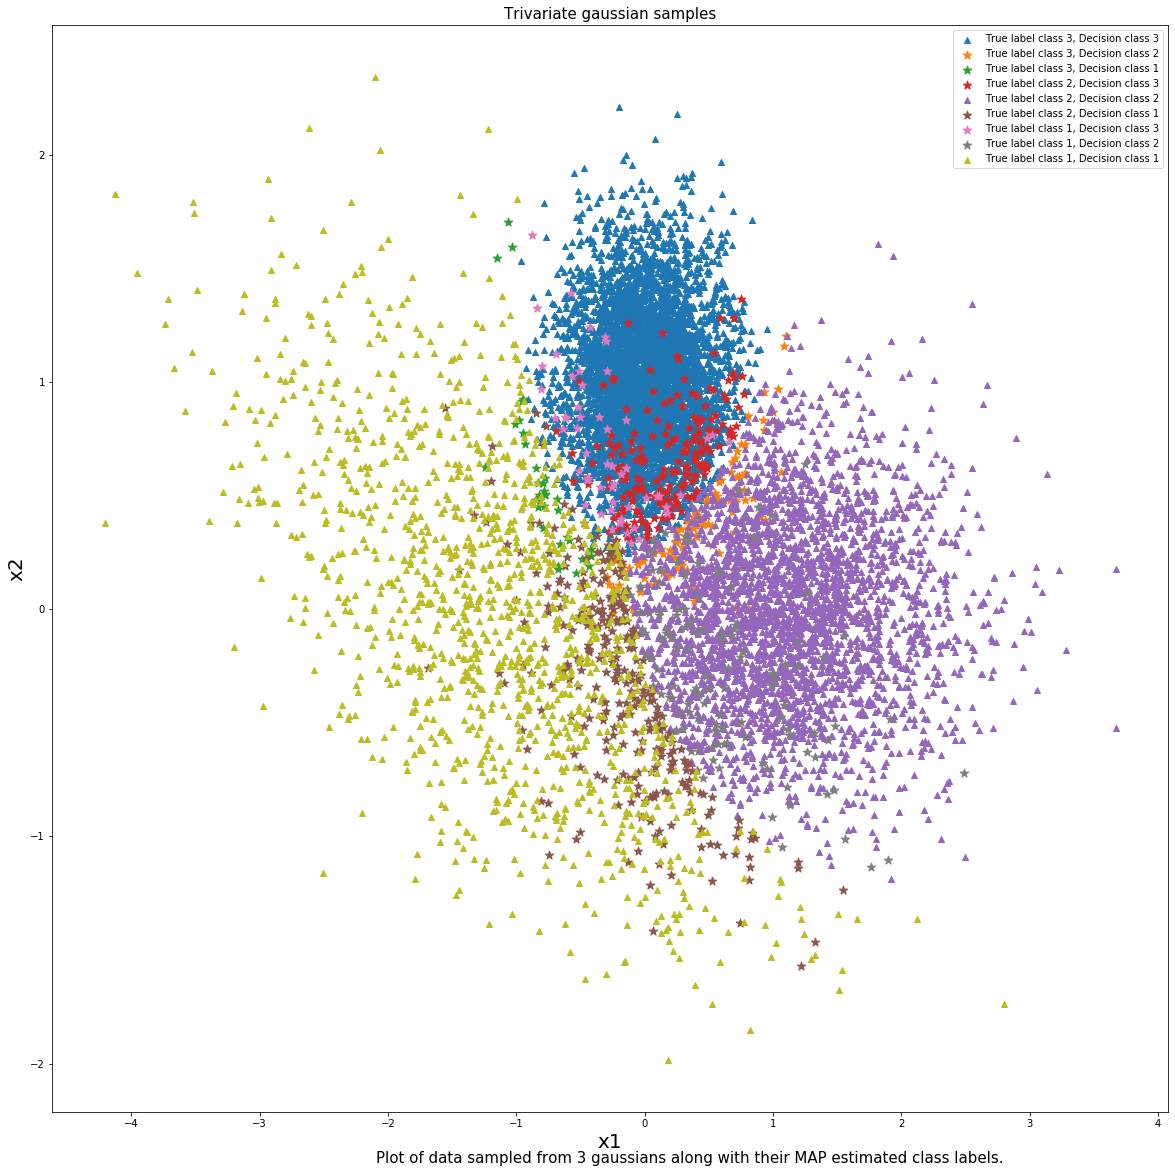

Samples from class 1 -  1445
Samples from class 2 -  3504
Samples from class 3 -  5051


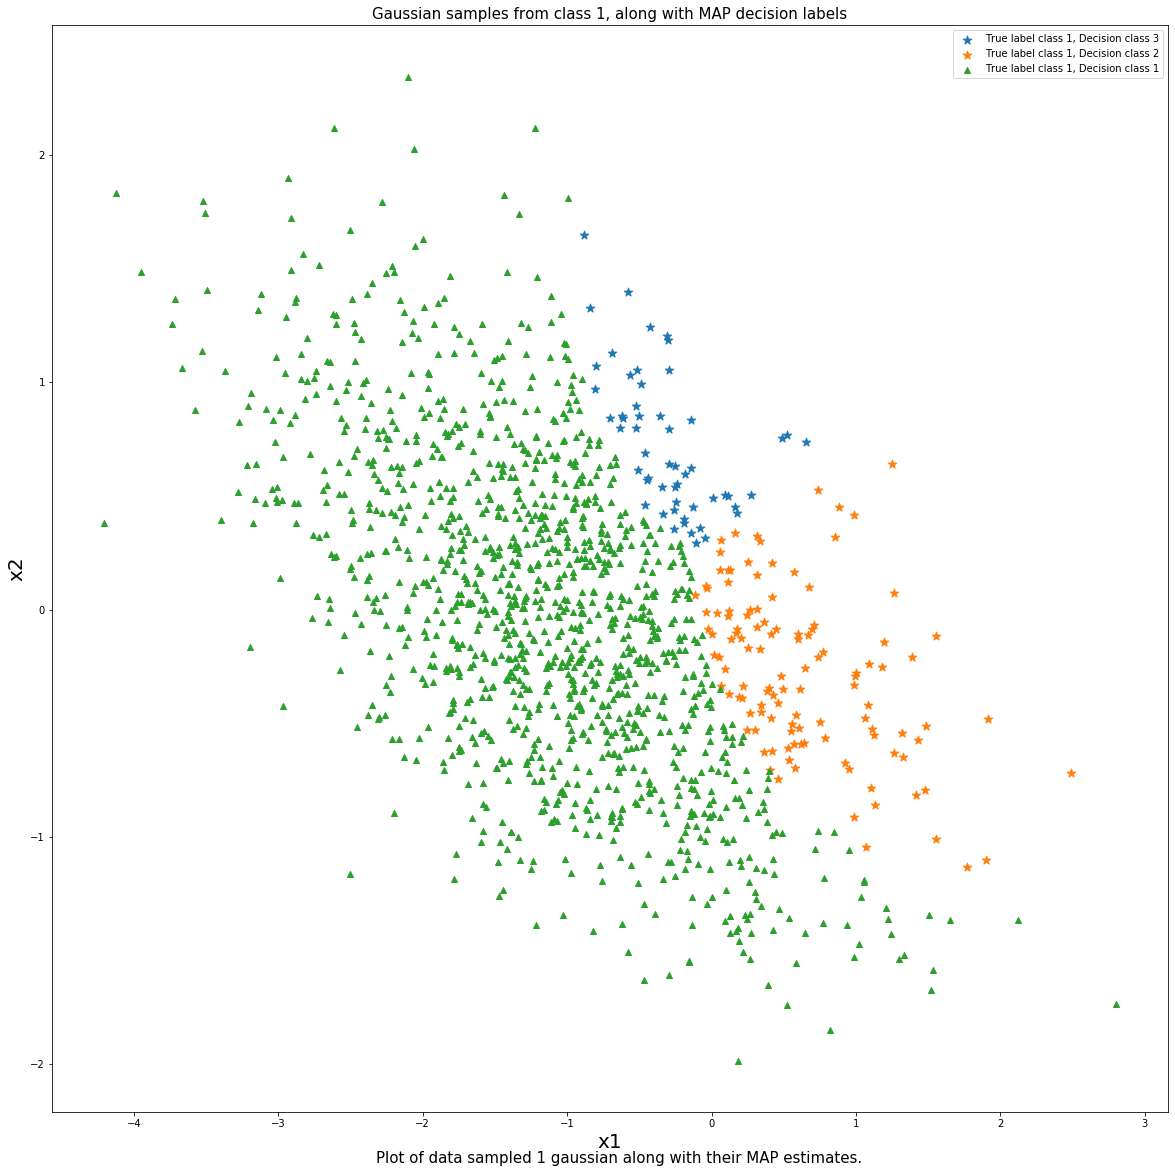



\n


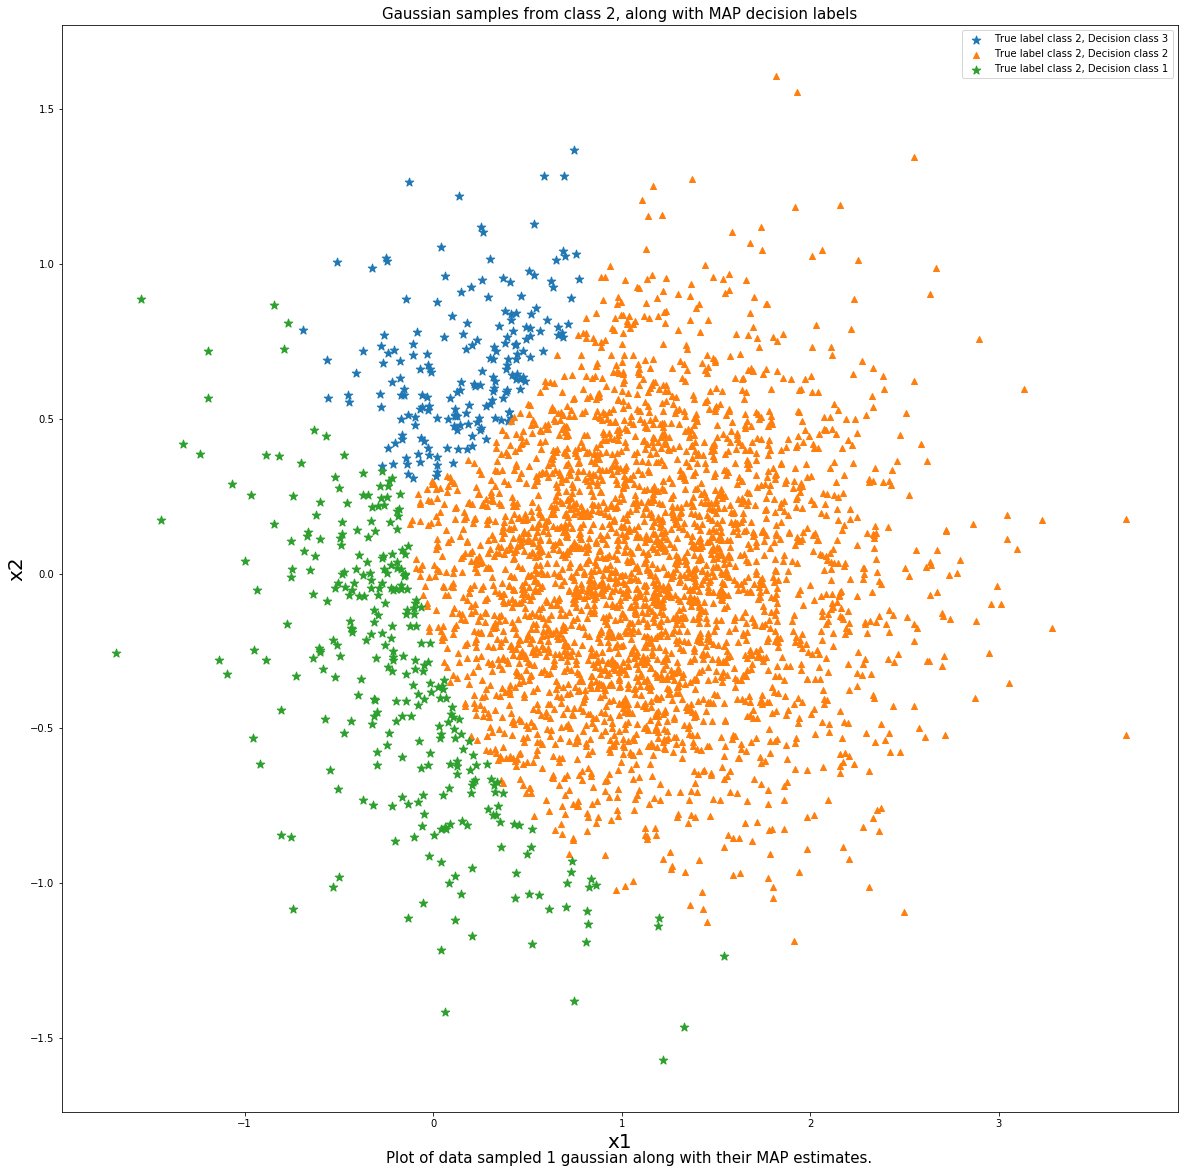



\n


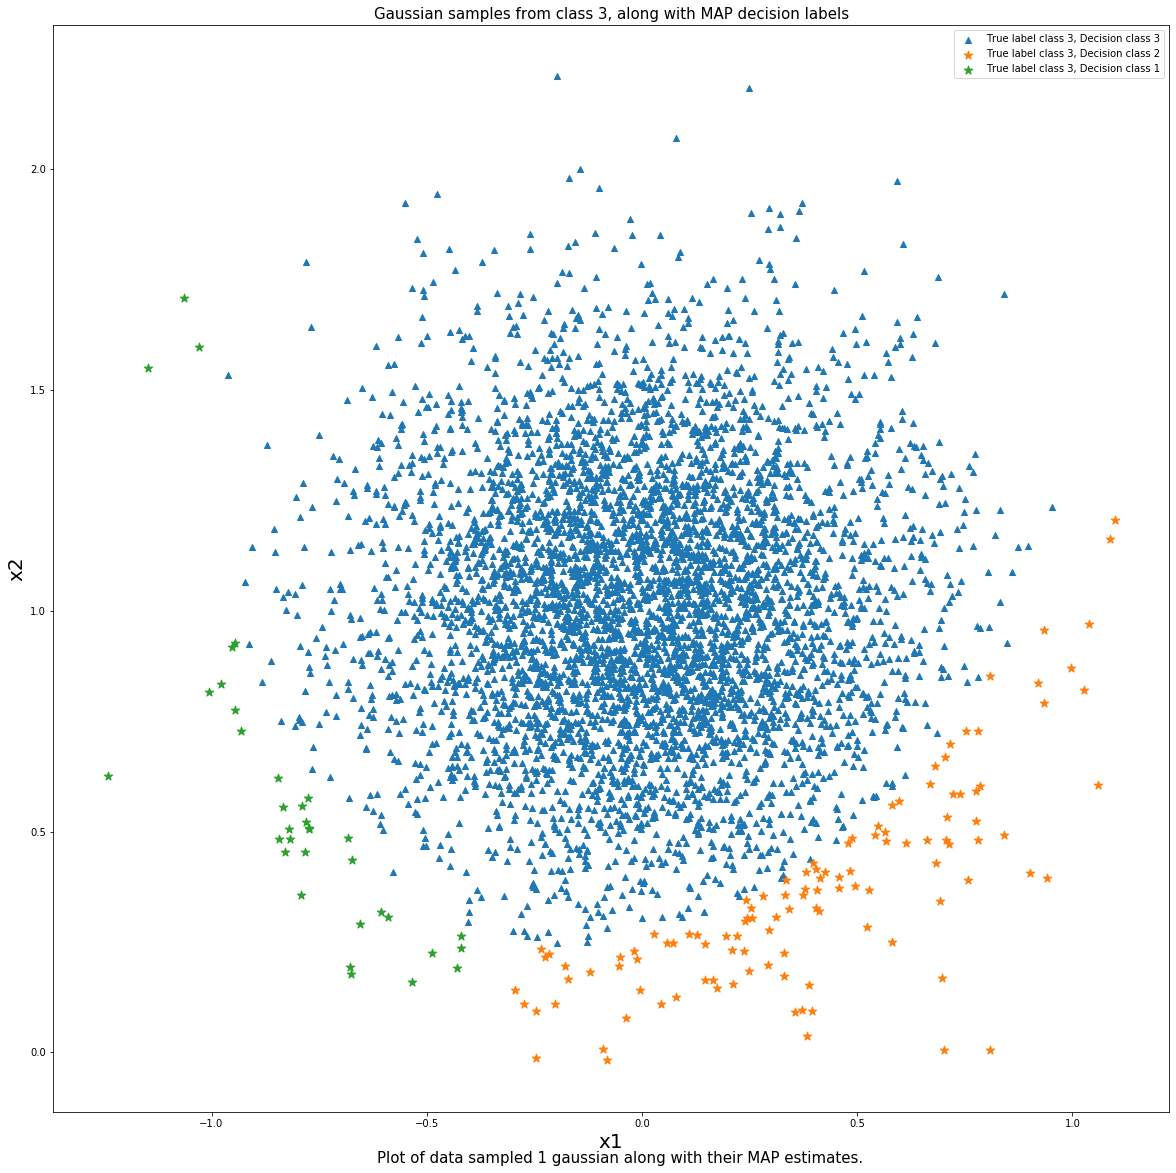

In [188]:
df=generate_GMM_samples(prior=[0.15,0.35],number_of_samples=10000,sig1=[[1,-0.4],[-0.4,0.5]],sig2=[[0.5,0],[0,0.2]],sig3=[[0.1,0],[0,0.1]],u1=[-1,0],u2=[1,0],u3=[0,1]);

In [189]:
print ("Columns have the True class; \nand Rows have decided class. \n Confusion matrix below")
df.style.apply(highlight_max)


Columns have the True class; 
and Rows have decided class. 
 Confusion matrix below


In [190]:
print("Total samples misclassified : ",df.mask(np.eye(3, dtype = bool)).sum().sum())
print("P(error) : ",(df.mask(np.eye(3, dtype = bool)).sum().sum())/100,"%")

Total samples misclassified :  812.0
P(error) :  8.12 %


With just 8% P(error), MAP classifier correctly classifies majority of the points
Samples where class conditional of true class label is high, are correctly classified. As the points are fairly distributed, mojority of the points are that way. 

For eg. consider class i. 

Posterior(i)=P(x|class =i)* P(i). 

This is compared against Posterior of all classes j,k.a, j!=i

The class conditional (P(x|class =i)) is gaussian. Exponential decaying function. As seperation of classes increases, "class conditional" is the main dominating term. As the exponentials evaluated at large distances decay way faster than difference in class priors of class i and j. Class priors are fixed, and roughly on the same order for all classes. Since the points are fairly scattered, MAP classifier gives just 8% P(error)
